In [1]:
import torch
import numpy as np

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource

output_notebook()

Loading BokehJS ...

In [2]:
from word2vec.model import EmbeddingModel
from word2vec.vocab import Vocab

In [3]:
CKPT_PATH = "checkpoints/epoch=4-step=735555.ckpt"
VOCAB_PATH = "checkpoints/vocab.json"

In [4]:
vocab = Vocab.load(VOCAB_PATH)
model = EmbeddingModel.load_from_checkpoint(CKPT_PATH, map_location="cpu")

/home/satwik/mambaforge/envs/insight/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.0.7
  rank_zero_warn(


In [5]:
word_embedding = model.word_embedding
word_embedding

Embedding(28793, 300)

In [6]:
def get_embedding(word):
    idx = vocab.encode([word])[0]
    return word_embedding(torch.tensor(idx)).detach().numpy()

In [7]:
def cosine_similarity(embed_a, embed_b):
    return np.dot(embed_a, embed_b) / (
        np.linalg.norm(embed_a) * np.linalg.norm(embed_b)
    )

In [8]:
def euclidean_distance(embed_a, embed_b):
    return np.sqrt(np.sum((embed_a - embed_b) ** 2))

In [9]:
def dot_product(embed_a, embed_b):
    return np.dot(embed_a, embed_b)

In [10]:
words = ("tv", "comedy")
embeddings = [get_embedding(word) for word in words]
cosine_similarity(*embeddings), euclidean_distance(*embeddings), dot_product(*embeddings)

(0.40642762, 4.504717, 6.872764)

In [11]:
def similar_words(word, metric=cosine_similarity):
    embeddings = get_embedding(word)
    similarities = [
        metric(embeddings, get_embedding(word)) for word in vocab.word2idx
    ]

    # Sort and get top 10 most similar words and their cosine similarity
    sorted_similarities = sorted(
        zip(similarities, vocab.word2idx), reverse=True
    )
    return sorted_similarities[:10]

In [12]:
# Get analogy
def analogy(word_a, word_b, word_c, metric=cosine_similarity):
    embedding_a = get_embedding(word_a)
    embedding_b = get_embedding(word_b)
    embedding_c = get_embedding(word_c)
    embedding_d = embedding_c + embedding_b - embedding_a

    similarities = [
        metric(embedding_d, get_embedding(word))
        for word in vocab.word2idx
    ]
    sorted_similarities = sorted(
        zip(similarities, vocab.word2idx), reverse=True
    )
    return sorted_similarities[:10]

In [13]:
similar_words("artillery")

[(1.0, 'artillery'),
 (0.55945635, 'battery'),
 (0.5228575, 'battalion'),
 (0.50890076, 'regiments'),
 (0.5006646, 'shelling'),
 (0.49702987, 'ottoman'),
 (0.4927736, 'howitzers'),
 (0.4827104, 'bayonet'),
 (0.48132917, 'infantry'),
 (0.4784448, 'redoubts')]

In [14]:
analogy("son", "father", "daughter")

[(0.75376076, 'daughter'),
 (0.5701034, 'father'),
 (0.4244268, 'mother'),
 (0.3807127, 'daughters'),
 (0.33759993, 'parents'),
 (0.33531103, 'eldest'),
 (0.32939386, 'susanna'),
 (0.32528082, 'married'),
 (0.32503176, 'meri'),
 (0.31788656, '1616')]

In [15]:
embeddings = [get_embedding(word) for word in vocab.word2idx]
embeddings = np.array(embeddings)
embeddings.shape

(28793, 300)

In [16]:
tsne = TSNE(n_components=2, metric="cosine", random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

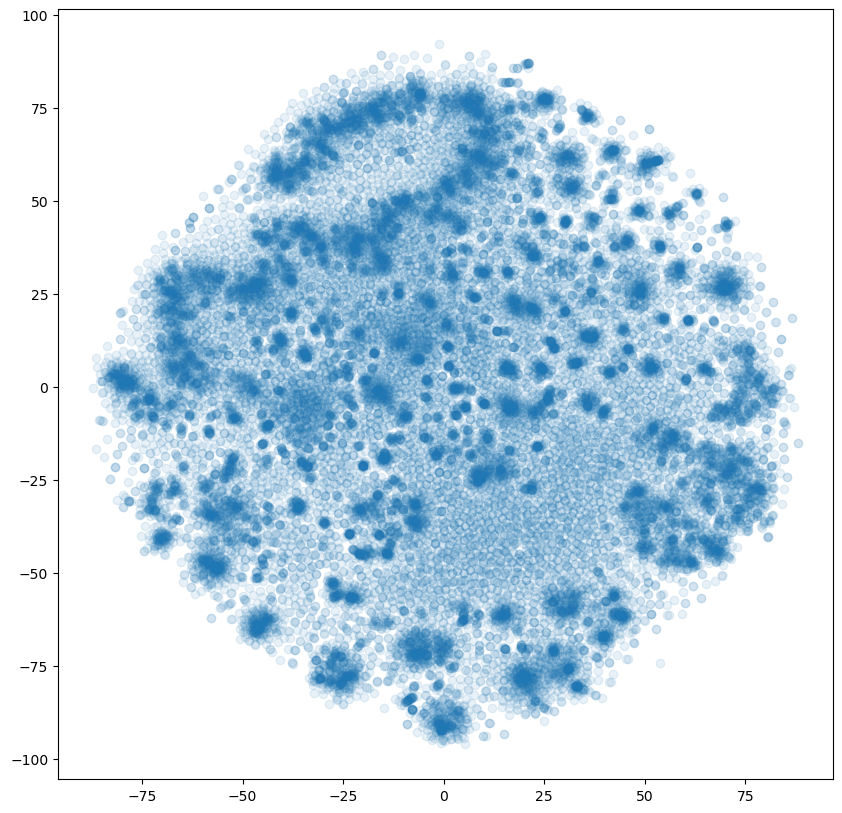

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.1)

In [18]:
# Make interactive plot with bokeh
source = ColumnDataSource(
    data=dict(
        x1=embeddings_2d[:, 0],
        x2=embeddings_2d[:, 1],
        word_id=list(range(embeddings_2d.shape[0])),
        names=list(vocab.word2idx.keys()),
    )
)

hover = HoverTool(tooltips=[("word", "@names")])

p = figure(
    width=800,
    height=800,
    tools=[hover, "pan", "wheel_zoom", "save", "reset"],
    title="Word embeddings",
)

p.circle("x1", "x2", size=8, source=source, alpha=0.1)

show(p)

In [ ]:
output_file("word_embeddings.html", title="Word Embeddings")
save(p)